
# Phase 1 — Exploratory Data Analysis (EDA)

This notebook inspects the cleaned dataset and produces both **inline plots** and
**saved artifacts** under `notebooks/reports/figures/` plus a compact JSON summary under
`notebooks/reports/eda_summary.json`.

**Sections**
1. Setup & data loading (with safe fallbacks)
2. Dataset overview & sanity checks
3. Daily rhythms (time series, weekdays, slots)
4. Study location vs productivity
5. Sleep vs productivity (scatter + trend line)
6. Meals vs productivity (mean ± 95% CI)
7. Mood & social context
8. Artifact index (what was saved to disk)


In [5]:

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (8, 4), "axes.grid": True})
NB_DIR = Path(__file__).parent if "__file__" in globals() else Path.cwd()
FIG_DIR = NB_DIR / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_PATH = NB_DIR / "reports" / "eda_summary.json"
SUMMARY_PATH.parent.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    p = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(p, dpi=160, bbox_inches="tight")
    print(f"saved: {p}")



## 1) Load data (cleaned parquet preferred, with fallbacks)

The loader prefers your real cleaned parquet (`data/interim/clean.parquet`). If not present,
it falls back to `data/sample/clean_sample.parquet` or the sample CSV.


In [6]:

from pathlib import Path
import pandas as pd

def find_project_root(start: Path = Path.cwd()) -> Path:
    """
    Walk up from 'start' to find the first folder that looks like the repo root
    (has pyproject.toml or .git). Fallback to 'start' if nothing found.
    """
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists():
            return p
    return start

ROOT = find_project_root()
DATA = ROOT / "data"
INTERIM = DATA / "interim"
SAMPLE = DATA / "sample"

print("Notebook CWD:", Path.cwd())
print("Detected project root:", ROOT)

def load_df() -> pd.DataFrame:
    if (INTERIM / "clean.parquet").exists():
        print("Loading:", INTERIM / "clean.parquet")
        return pd.read_parquet(INTERIM / "clean.parquet")
    if (SAMPLE / "clean_sample.parquet").exists():
        print("Loading:", SAMPLE / "clean_sample.parquet")
        return pd.read_parquet(SAMPLE / "clean_sample.parquet")
    if (SAMPLE / "cte_sample.csv").exists():
        print("Loading:", SAMPLE / "cte_sample.csv")
        return pd.read_csv(SAMPLE / "cte_sample.csv")
    raise FileNotFoundError(
        f"Couldn’t find a dataset. Looked for:\n"
        f"  - {INTERIM/'clean.parquet'}\n"
        f"  - {SAMPLE/'clean_sample.parquet'}\n"
        f"  - {SAMPLE/'cte_sample.csv'}"
    )

df = load_df()
df.head(3)


Notebook CWD: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks
Detected project root: /Users/deo/UMKC_phd/project_related/job_related/cte-project
Loading: /Users/deo/UMKC_phd/project_related/job_related/cte-project/data/interim/clean.parquet


,date,wakeup_time_minutes,dinner_time_minutes,bed_time_minutes,sleep_duration_h,productivity_pct,deep_sleep_pct,rem_sleep_pct,water_drank_l,studied_at_home,...,reflection,primary_mood,secondary_mood,when_most_productive,interaction_partner,interaction_family,interaction_friends,dinner_time,bed_time,wakeup_time
0,2025-01-27,393,1240,1335,7.633333,75.0,21.0,8.0,1.5,1,...,I think i did good today for my first day on t...,motivated,happy,1,positive,na,na,8:40 PM,10:15 PM,6:33 AM
1,2025-01-28,443,1215,1320,9.100000,0.0,21.0,5.0,1.0,0,...,"Well, i did pretty bad today, couldn't get goi...",happy,overwhelmed,5,positive,positive,positive,8:15 PM,10:00 PM,7:23 AM
2,2025-01-29,370,1230,1339,7.933333,10.0,21.0,4.0,1.8,1,...,"i started good, maybe for first few minutes an...",overwhelmed,sad,1,positive,na,positive,8:30 PM,10:19 PM,6:10 AM



## 2) Quick dataset overview & sanity checks


In [7]:

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDate range (if available):")
if "date" in df.columns:
    print(pd.to_datetime(df["date"]).min(), "→", pd.to_datetime(df["date"]).max())

# Show missingness % for key numeric columns
key_numeric = [
    "productivity_pct", "sleep_duration_h", "deep_sleep_pct", "rem_sleep_pct",
    "wakeup_time_minutes", "bed_time_minutes", "dinner_time_minutes"
]
present = [c for c in key_numeric if c in df.columns]
if present:
    miss = df[present].isna().mean().sort_values(ascending=False).to_frame("missing_frac")
    display(miss.T)


Shape: (72, 56)
Columns: ['date', 'wakeup_time_minutes', 'dinner_time_minutes', 'bed_time_minutes', 'sleep_duration_h', 'productivity_pct', 'deep_sleep_pct', 'rem_sleep_pct', 'water_drank_l', 'studied_at_home', 'studied_at_school', 'workout_did', 'meditation', 'morning_shower', 'played_sports', 'sickness', 'nap_today', 'partner_score', 'partner_no_interaction', 'family_score', 'family_no_interaction', 'friends_score', 'friends_no_interaction', 'breakfast_no_meal', 'breakfast_carb_heavy', 'breakfast_protein_heavy', 'breakfast_fat_heavy', 'breakfast_balanced', 'lunch_no_meal', 'lunch_carb_heavy', 'lunch_protein_heavy', 'lunch_fat_heavy', 'lunch_balanced', 'dinner_no_meal', 'dinner_carb_heavy', 'dinner_protein_heavy', 'dinner_fat_heavy', 'dinner_balanced', 'breakfast_quality', 'lunch_quality', 'dinner_quality', 'when_most_productive_decoded', 'prod_morning', 'prod_afternoon', 'prod_evening', 'prod_none', 'reflection', 'primary_mood', 'secondary_mood', 'when_most_productive', 'interaction_

,productivity_pct,sleep_duration_h,deep_sleep_pct,rem_sleep_pct,wakeup_time_minutes,bed_time_minutes,dinner_time_minutes
missing_frac,0.0,0.0,0.0,0.0,0.0,0.0,0.0



## 3) Daily rhythms
**Why:** Get a feel for trends across time and by weekday; summarize how often multiple productivity slots happen.


saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_over_time.png


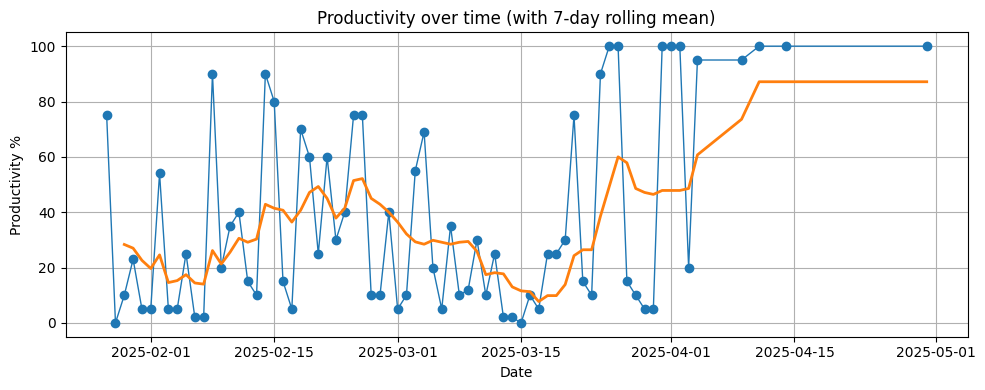

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_weekday.png


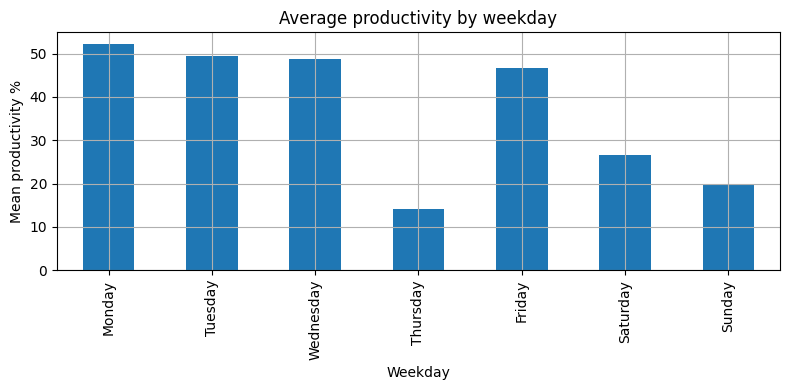

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_vs_num_prod_slots.png


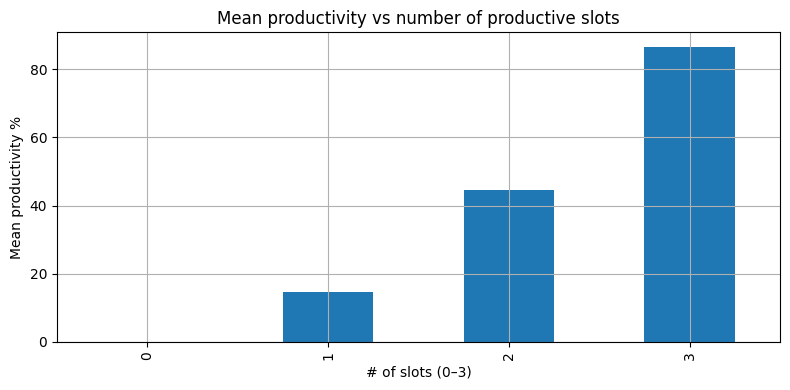

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/when_most_productive_distribution.png


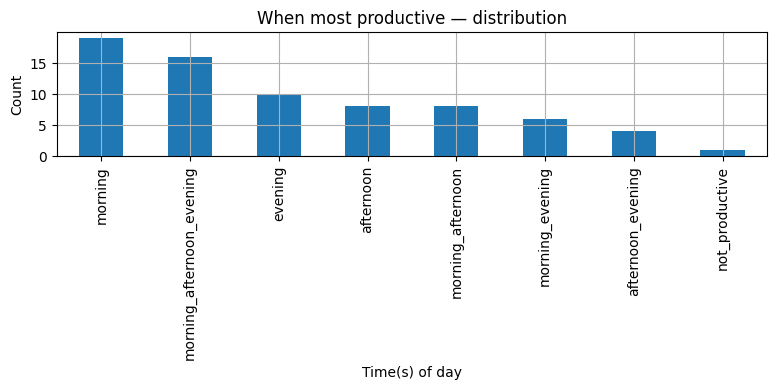

In [8]:

# Time series of productivity
if "date" in df.columns and "productivity_pct" in df.columns:
    tmp = df[["date", "productivity_pct"]].dropna().copy()
    tmp["date"] = pd.to_datetime(tmp["date"])
    tmp = tmp.sort_values("date")
    tmp["roll7"] = tmp["productivity_pct"].rolling(7, min_periods=3).mean()
    plt.figure(figsize=(10,4))
    plt.plot(tmp["date"], tmp["productivity_pct"], marker="o", lw=1)
    if tmp["roll7"].notna().any():
        plt.plot(tmp["date"], tmp["roll7"], lw=2)
    plt.title("Productivity over time (with 7-day rolling mean)")
    plt.xlabel("Date"); plt.ylabel("Productivity %")
    savefig("prod_over_time.png")
    plt.show()

# By weekday
if "date" in df.columns and "productivity_pct" in df.columns:
    tmp = df[["date", "productivity_pct"]].dropna().copy()
    tmp["weekday"] = pd.to_datetime(tmp["date"]).dt.day_name()
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    m = tmp.groupby("weekday")["productivity_pct"].mean().reindex(order)
    plt.figure()
    m.plot(kind="bar")
    plt.title("Average productivity by weekday")
    plt.xlabel("Weekday"); plt.ylabel("Mean productivity %")
    savefig("prod_by_weekday.png")
    plt.show()

# Number of productive slots (morning/afternoon/evening)
cols = [c for c in ["prod_morning","prod_afternoon","prod_evening"] if c in df.columns]
if cols and "productivity_pct" in df.columns:
    tmp = df[cols + ["productivity_pct"]].dropna(subset=["productivity_pct"]).copy()
    tmp["num_slots"] = tmp[cols].fillna(0).astype(int).sum(axis=1)
    m = tmp.groupby("num_slots")["productivity_pct"].mean().reindex([0,1,2,3])
    plt.figure()
    m.plot(kind="bar")
    plt.title("Mean productivity vs number of productive slots")
    plt.xlabel("# of slots (0–3)"); plt.ylabel("Mean productivity %")
    savefig("prod_vs_num_prod_slots.png")
    plt.show()

# Distribution of when_most_productive_decoded
if "when_most_productive_decoded" in df.columns:
    vc = df["when_most_productive_decoded"].value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title("When most productive — distribution")
    plt.xlabel("Time(s) of day"); plt.ylabel("Count")
    savefig("when_most_productive_distribution.png")
    plt.show()



## 4) Study location vs productivity
**Why:** Measure the effect of study environment.


saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_study_location.png


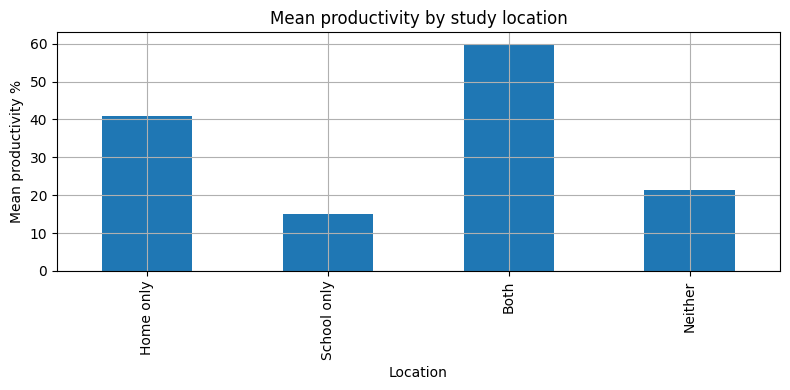

In [9]:

if {"studied_at_home","studied_at_school","productivity_pct"}.issubset(df.columns):
    s = df[["studied_at_home","studied_at_school","productivity_pct"]].dropna(subset=["productivity_pct"]).copy()
    s["home"] = s["studied_at_home"].fillna(0).astype(int)
    s["school"] = s["studied_at_school"].fillna(0).astype(int)

    def loc_label(row):
        if row["home"]==1 and row["school"]==1: return "Both"
        if row["home"]==1 and row["school"]==0: return "Home only"
        if row["home"]==0 and row["school"]==1: return "School only"
        return "Neither"

    s["location"] = s.apply(loc_label, axis=1)
    m = s.groupby("location")["productivity_pct"].mean().reindex(["Home only","School only","Both","Neither"])
    plt.figure()
    m.plot(kind="bar")
    plt.title("Mean productivity by study location")
    plt.xlabel("Location"); plt.ylabel("Mean productivity %")
    savefig("prod_by_study_location.png")
    plt.show()



## 5) Sleep vs productivity
**Why:** Check linear relationships for sleep quantity/quality.


saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/sleep_duration_vs_productivity.png


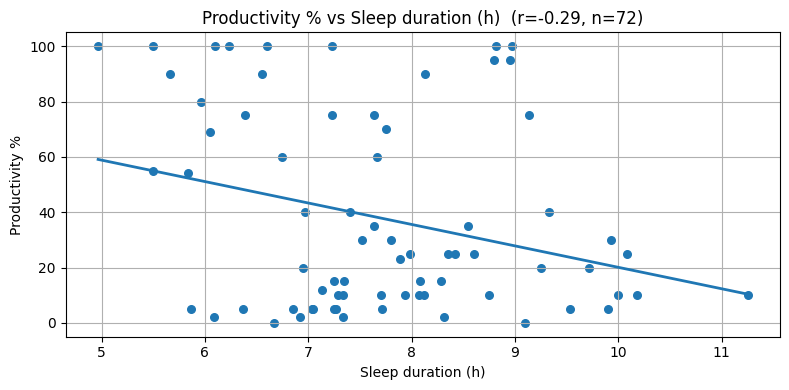

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/deep_sleep_pct_vs_prod.png


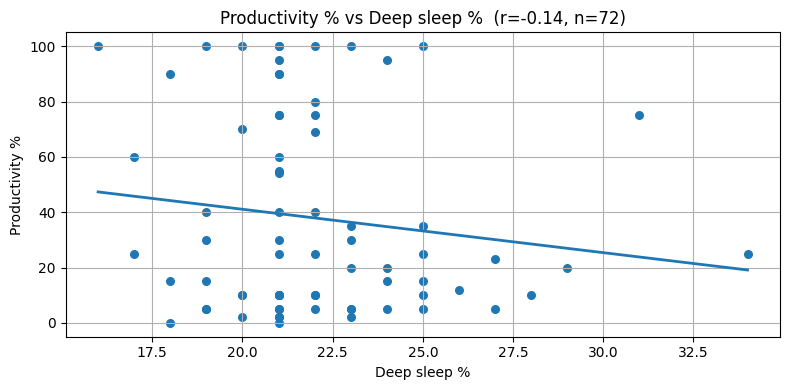

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/rem_sleep_pct_vs_prod.png


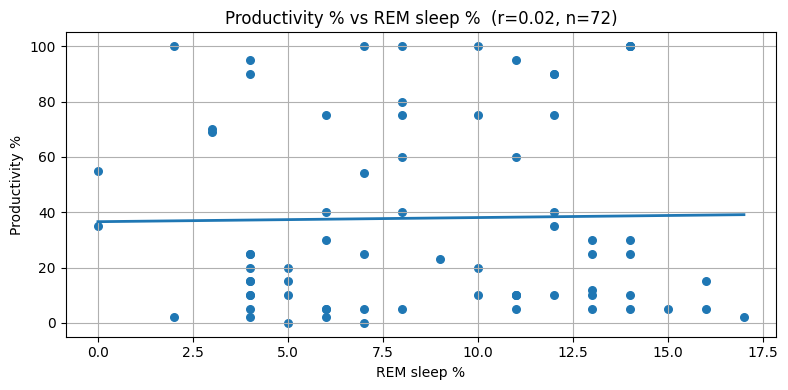

In [10]:

def scatter_with_trend(x, y, xlab, ylab, fname):
    z = df[[x,y]].dropna()
    if len(z) < 3:
        print(f"Skipping {fname} — not enough data")
        return
    r = z[x].corr(z[y])
    # simple linear fit
    coeffs = np.polyfit(z[x], z[y], 1)
    xs = np.linspace(z[x].min(), z[x].max(), 100)
    ys = coeffs[0]*xs + coeffs[1]
    plt.figure()
    plt.scatter(z[x], z[y], s=30)
    plt.plot(xs, ys, lw=2)
    plt.title(f"{ylab} vs {xlab}  (r={r:.2f}, n={len(z)})")
    plt.xlabel(xlab); plt.ylabel(ylab)
    savefig(fname)
    plt.show()

if {"sleep_duration_h","productivity_pct"}.issubset(df.columns):
    scatter_with_trend("sleep_duration_h","productivity_pct","Sleep duration (h)","Productivity %","sleep_duration_vs_productivity.png")

if {"deep_sleep_pct","productivity_pct"}.issubset(df.columns):
    scatter_with_trend("deep_sleep_pct","productivity_pct","Deep sleep %","Productivity %","deep_sleep_pct_vs_prod.png")

if {"rem_sleep_pct","productivity_pct"}.issubset(df.columns):
    scatter_with_trend("rem_sleep_pct","productivity_pct","REM sleep %","Productivity %","rem_sleep_pct_vs_prod.png")



## 6) Meals vs productivity (mean ± 95% CI)
**Why:** Compare average productivity across meal-quality categories.


saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_breakfast_quality_ci.png


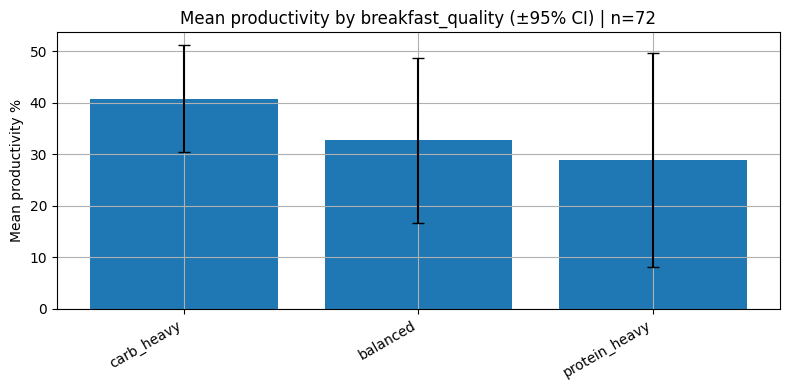

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_lunch_quality_ci.png


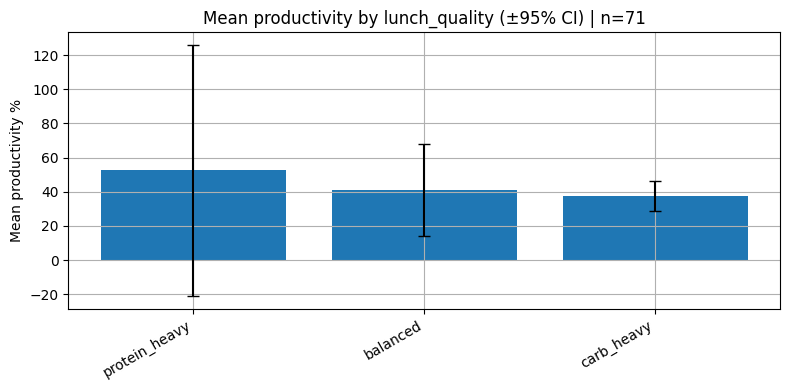

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_dinner_quality_ci.png


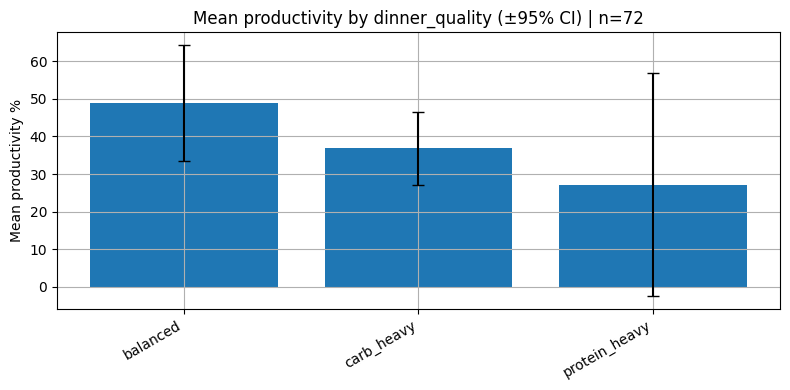

In [11]:

def mean_ci_plot(label_col, ylabel, fname):
    if label_col not in df.columns or "productivity_pct" not in df.columns:
        print(f"Skipping {fname} — missing columns")
        return
    tmp = df[[label_col,"productivity_pct"]].dropna().copy()
    if tmp.empty:
        print(f"Skipping {fname} — no data")
        return
    g = tmp.groupby(label_col)["productivity_pct"]
    mean = g.mean()
    count = g.count()
    std = g.std(ddof=1)
    se = std / np.sqrt(count)
    ci = 1.96 * se

    # sort by mean descending for readability
    order = mean.sort_values(ascending=False).index.tolist()
    mean = mean.loc[order]; ci = ci.loc[order]; count = count.loc[order]

    x = np.arange(len(mean))
    plt.figure()
    plt.bar(x, mean.values, yerr=ci.values, capsize=4)
    plt.xticks(x, order, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(f"Mean productivity by {label_col} (±95% CI) | n={int(count.sum())}")
    savefig(fname)
    plt.show()

mean_ci_plot("breakfast_quality","Mean productivity %","prod_by_breakfast_quality_ci.png")
mean_ci_plot("lunch_quality","Mean productivity %","prod_by_lunch_quality_ci.png")
mean_ci_plot("dinner_quality","Mean productivity %","prod_by_dinner_quality_ci.png")



## 7) Mood & social context
**Why:** Subjective mood and interaction quality may co-vary with productivity.


saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/prod_by_primary_mood_box.png


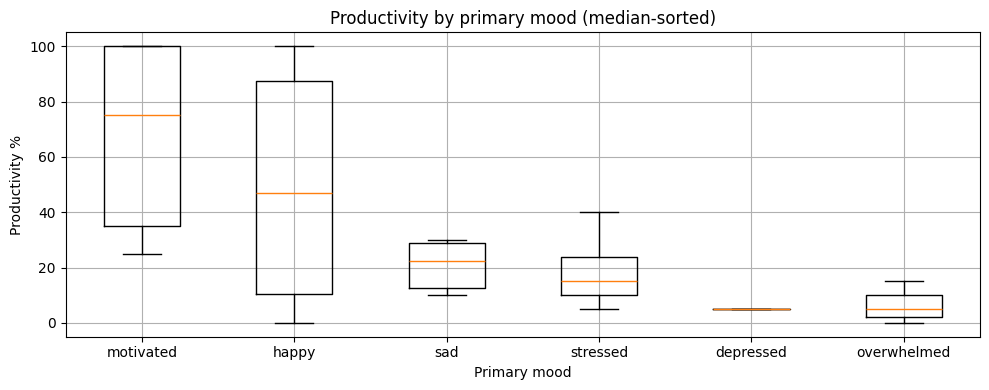

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/primary_mood_distribution.png


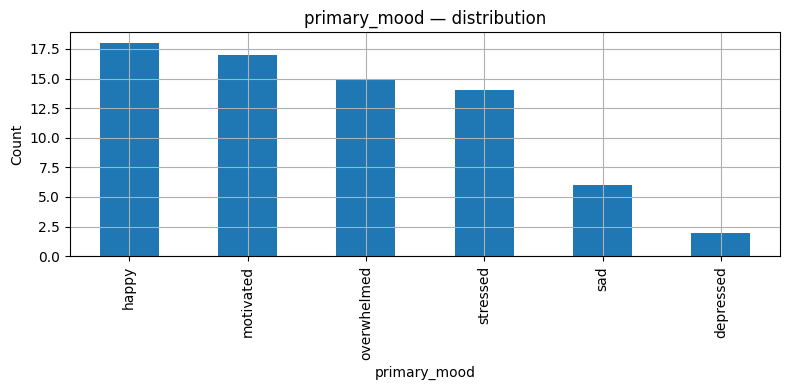

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/secondary_mood_distribution.png


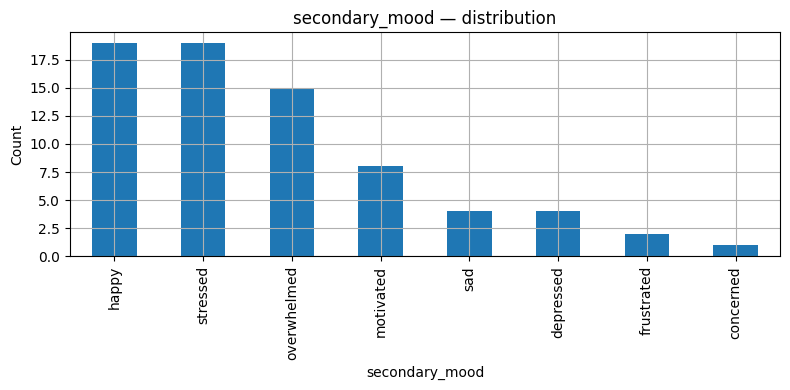

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/partner_score_mean.png


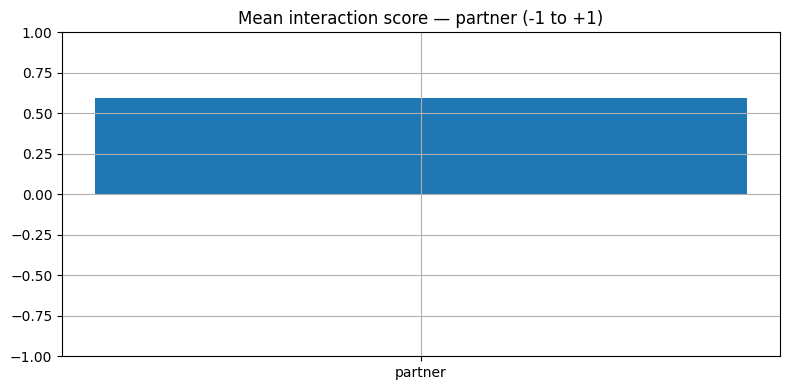

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/partner_no_interaction_rate.png


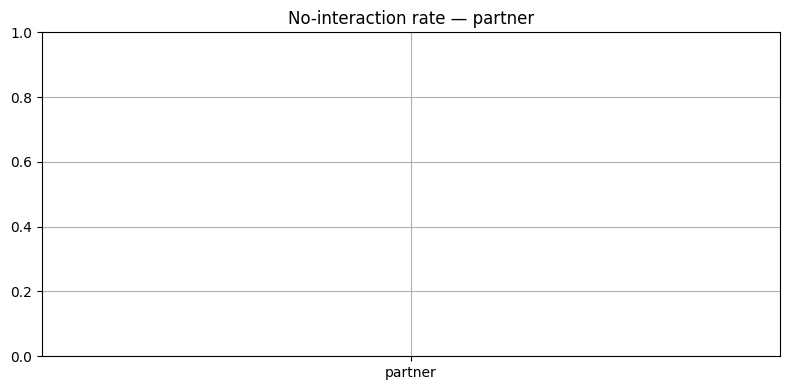

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/family_score_mean.png


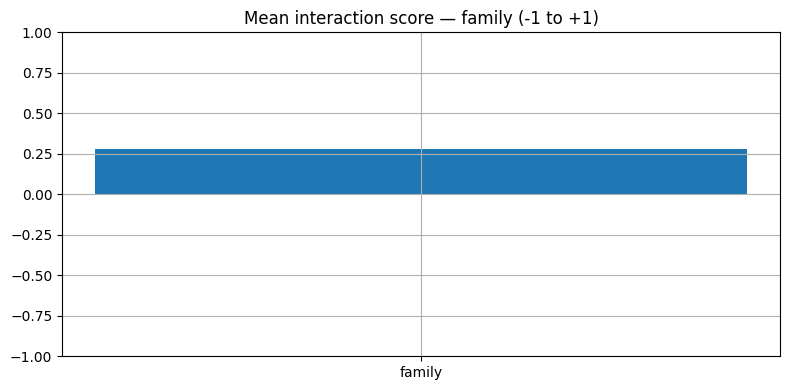

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/family_no_interaction_rate.png


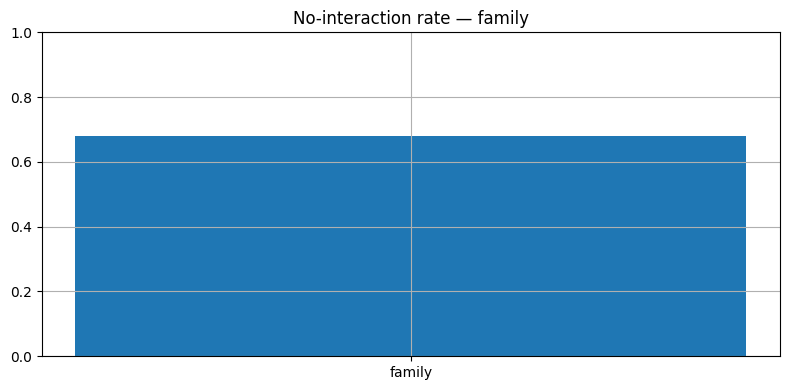

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/friends_score_mean.png


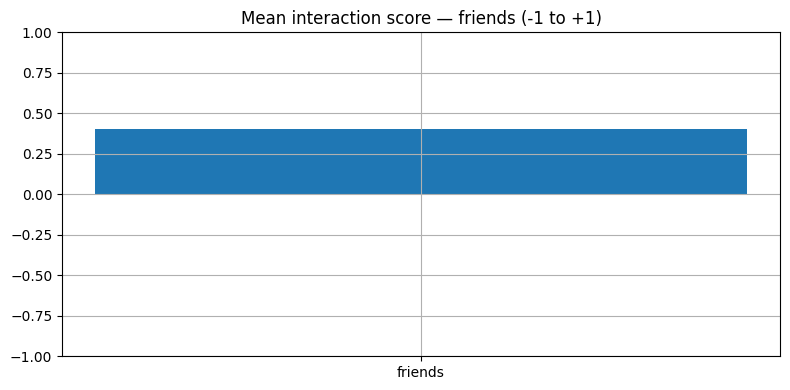

saved: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/figures/friends_no_interaction_rate.png


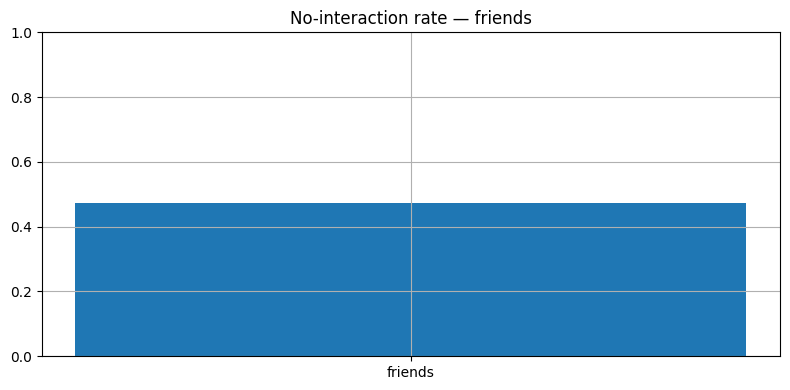

In [12]:

# Boxplot by primary mood
if {"primary_mood","productivity_pct"}.issubset(df.columns):
    tmp = df[["primary_mood","productivity_pct"]].dropna().copy()
    order = tmp.groupby("primary_mood")["productivity_pct"].median().sort_values(ascending=False).index.tolist()
    # build boxplot data in chosen order
    data = [tmp.loc[tmp["primary_mood"]==m, "productivity_pct"].values for m in order]
    plt.figure(figsize=(10,4))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.title("Productivity by primary mood (median-sorted)")
    plt.xlabel("Primary mood"); plt.ylabel("Productivity %")
    savefig("prod_by_primary_mood_box.png")
    plt.show()

# Mood distributions
for col, fname in [("primary_mood","primary_mood_distribution.png"),
                   ("secondary_mood","secondary_mood_distribution.png")]:
    if col in df.columns:
        vc = df[col].value_counts(dropna=False)
        plt.figure()
        vc.plot(kind="bar")
        plt.title(f"{col} — distribution")
        plt.xlabel(col); plt.ylabel("Count")
        savefig(fname)
        plt.show()

# Social interaction stats: mean score & no-interaction rate
def plot_social(base: str):
    score = f"{base}_score"
    nai = f"{base}_no_interaction"
    if score in df.columns:
        plt.figure()
        ser = df[score].dropna()
        if not ser.empty:
            plt.bar([base], [ser.mean()])
            plt.ylim(-1,1)
            plt.title(f"Mean interaction score — {base} (-1 to +1)")
            savefig(f"{base}_score_mean.png")
            plt.show()
    if nai in df.columns:
        ser2 = df[nai].dropna()
        if not ser2.empty:
            rate = ser2.mean()
            plt.figure()
            plt.bar([base], [rate])
            plt.ylim(0,1)
            plt.title(f"No-interaction rate — {base}")
            savefig(f"{base}_no_interaction_rate.png")
            plt.show()

for base in ["partner","family","friends"]:
    plot_social(base)



## 8) Artifact index (what was saved)


In [13]:

# Build a compact summary JSON and list saved figures
summary = {}

# Date range
if "date" in df.columns and not df["date"].isna().all():
    dmin = pd.to_datetime(df["date"]).min()
    dmax = pd.to_datetime(df["date"]).max()
    if pd.notna(dmin) and pd.notna(dmax):
        summary["date_min"] = str(dmin.date())
        summary["date_max"] = str(dmax.date())

# Selected correlations
def safe_corr(a,b):
    if a in df.columns and b in df.columns:
        s = df[[a,b]].dropna()
        if len(s) >= 2:
            return round(float(s[a].corr(s[b])), 3)
    return None

summary["corr_sleep_duration_h_vs_productivity_pct"] = safe_corr("sleep_duration_h","productivity_pct")
summary["corr_deep_sleep_pct_vs_productivity_pct"] = safe_corr("deep_sleep_pct","productivity_pct")
summary["corr_rem_sleep_pct_vs_productivity_pct"] = safe_corr("rem_sleep_pct","productivity_pct")

# Meal means
for meal in ["breakfast_quality", "lunch_quality", "dinner_quality"]:
    if meal in df.columns and "productivity_pct" in df.columns:
        tmp = df[[meal, "productivity_pct"]].dropna()
        if not tmp.empty:
            means = tmp.groupby(meal)["productivity_pct"].mean().round(2).to_dict()
            summary[f"mean_prod_by_{meal}"] = means

with open(SUMMARY_PATH, "w") as f:
    json.dump({k:v for k,v in summary.items() if v is not None}, f, indent=2)

print("Wrote:", SUMMARY_PATH)
print(json.dumps(summary, indent=2))

# List saved figures
figs = sorted([p.name for p in FIG_DIR.glob("*.png")])
print(f"\n{len(figs)} figures saved:")
for name in figs:
    print(" -", name)


Wrote: /Users/deo/UMKC_phd/project_related/job_related/cte-project/notebooks/reports/eda_summary.json
{
  "date_min": "2025-01-27",
  "date_max": "2025-04-30",
  "corr_sleep_duration_h_vs_productivity_pct": -0.288,
  "corr_deep_sleep_pct_vs_productivity_pct": -0.138,
  "corr_rem_sleep_pct_vs_productivity_pct": 0.018,
  "mean_prod_by_breakfast_quality": {
    "balanced": 32.69,
    "carb_heavy": 40.82,
    "protein_heavy": 28.89
  },
  "mean_prod_by_lunch_quality": {
    "balanced": 41.17,
    "carb_heavy": 37.6,
    "protein_heavy": 52.5
  },
  "mean_prod_by_dinner_quality": {
    "balanced": 48.91,
    "carb_heavy": 36.82,
    "protein_heavy": 27.17
  }
}

20 figures saved:
 - deep_sleep_pct_vs_prod.png
 - family_no_interaction_rate.png
 - family_score_mean.png
 - friends_no_interaction_rate.png
 - friends_score_mean.png
 - partner_no_interaction_rate.png
 - partner_score_mean.png
 - primary_mood_distribution.png
 - prod_by_breakfast_quality_ci.png
 - prod_by_dinner_quality_ci.png
 - 